In [2]:
import os
import numpy as np
import sys
import json
import glob
from nltk.tokenize import ToktokTokenizer, word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import math

In [3]:
plt.rcParams["figure.figsize"] = (20,10)

In [10]:
BASE_DIR = r'C:\Thesis\Homicide_dataset_clean'

# 1. Clean

In [4]:
def clean(line):
    line = line.strip().replace("newline_char", " ")
    line = line.replace("( opens in new window )", "")
    line = line.replace("click to email this to a friend", "")
    line = line.replace("lick to share on whatsapp", "")
    line = line.replace("click to share on facebook", "")
    line = line.replace("share on facebook", "")
    line = line.replace("click to share on twitter", "")
    line = line.replace("click to share on pinterest", "")
    line = line.replace("click to share on tumblr", "")
    line = line.replace("click to share on google+", "")
    line = line.replace("feel free to share these resources in your social "
                        "media networks , websites and other platforms", "")
    line = line.replace("share share tweet link", "")
    line = line.replace("e-mail article print share", "")
    line = line.replace("read or share this story :", "")
    line = line.replace("share the map view in e-mail by clicking the share "
                        "button and copying the link url .     embed the map "
                        "on your website or blog by getting a snippet of html "
                        "code from the share button .     if you wish to "
                        "provide feedback or comments on the map , or if "
                        "you are aware of map layers or other "
                        "datasets that you would like to see included on our maps , "
                        "please submit them for our evaluation using this this form .", "")
    line = line.replace("share this article share tweet post email", "")
    line = line.replace("skip in skip x embed x share close", "")
    line = line.replace("share tweet pin email", "")
    line = line.replace("share on twitter", "")
    line = line.replace("feel free to weigh-in yourself , via"
                        "the comments section . and while you ’ "
                        "re here , why don ’ t you sign up to "
                        "follow us on twitter us on twitter .", "")
    line = line.replace("follow us on facebook , twitter , instagram and youtube", "")
    line = line.replace("follow us on twitter", "")
    line = line.replace("follow us on facebook", "")
    line = line.replace("play facebook twitter google plus embed", "")
    line = line.replace("play facebook twitter embed", "")
    line = line.replace("enlarge icon pinterest icon close icon", "")
    line = line.replace("follow on twitter", "")
    line = line.replace("autoplay autoplay copy this code to your website or blog", "")
    return line


In [5]:
def clean_summary_str(s):
    s = s.lower()
    s = s.replace('<unk>','')
#     s = s.replace('`', '')
#     s = s.replace('.', '')
#     s = s.replace(',', '')
#     s = s.replace(';', '')
#     s = s.replace('\'', '')
#     s = s.replace('\"', '')
#     s = s.replace('(', '')
#     s = s.replace(')', '')
#     s = s.replace('-', ' ')
    s = s.replace('<p>', '')
    s = s.replace('</p>', '')
    s = s.replace('<t>', '')
    s = s.replace('</t>', '')
    s = s.replace('[!@#$]', '')
    return s

### Remove cookies - there are 27 files with only cookie information, and more files where the most of the text after a certain point is just cookie policy. We remove the former and clean the latter.

In [6]:
def remove_cookies(directory):
    directories = []
    i = 0
    keywords = ['Talpa Network', 'ZEMBLA-weekly', 'ZEMBLA-nieuwsbrief', 'Pijper']
    for subdir, dirs, files in os.walk(directory):
        if(i == 0):
            directories = dirs
            i+=1
        else:
            for file in files:
                file_path = os.path.join(subdir, file)
                doc = open(file_path, 'r', encoding='utf-8')
                text = doc.read()
                doc.close()
                if any(keyword in text for keyword in keywords):
                    if os.path.isfile(file_path):
                        os.remove(file_path)
                    else:
                        print("Error: %s file not found" % file_path)
                else:
                    keyword = ''
                    if('NOS gebruikt' in text):
                        keyword = 'NOS gebruikt'
                    elif('NIS uses' in text):
                        keyword = 'NIS uses'
                    if(keyword):
                        #get rid of the text regarding cookies
                        new_text = text.split(keyword)[0]
                        doc = open(file_path, 'w', encoding='utf-8')
                        doc.write(new_text)
                        doc.close()

In [16]:
working_dir = BASE_DIR + '\dataset_original_en_no_dots_no_cookies'

In [15]:
remove_cookies(working_dir)

# 2. Add number padding and tokenize.

In [17]:
working_dir = BASE_DIR + '\dataset_original_en_no_dots_no_cookies_truncated'

In [18]:
#add padding (e.g. case id 3 becomes 003, etc.)
for dirs in os.walk(working_dir):
    old_directories = dirs[1]
    for folder in old_directories:
        old_folder = os.path.join(working_dir, folder)
        old_id = folder.split('_')[2]
        new_id = old_id.zfill(3)
        new_folder = old_folder.replace(old_id, new_id)
        os.rename(old_folder, new_folder)

In [19]:
def clean_archive_data(folder):
    if not os.path.exists(f"{folder}_cleaned"):
        os.makedirs(f"{folder}_cleaned")
    for count, file in enumerate(os.listdir(f"{folder}")):
        file_data = open(f"{folder}/{file}", "r", encoding='utf-8').read()
        tokenized_text = word_tokenize(file_data)
        tokenized_text_cleaned = list(map(clean_summary_str, tokenized_text))
        tokenized_text_cleaned_noempty = filter(None, tokenized_text_cleaned)
        tokenized_text_cleaned_noempty = clean(" ".join(tokenized_text_cleaned_noempty))
        with open(f"{folder}_cleaned/{file}", "w", encoding='utf-8') as output:
            output.write(tokenized_text_cleaned_noempty)
    shutil.rmtree(folder)

In [20]:
#get new directories
directories = []
for subdir, dirs, files in os.walk(working_dir):
    directories = dirs
    break

#tokenize and clean data
for k in range(0,100):
    clean_archive_data(os.path.join(working_dir, directories[k]))

Get documents with length under a given threshold

In [54]:
def docs_by_length(directory, length):
    result = []
    directories = []
    i = 0
    for subdir, dirs, files in os.walk(directory):
        if(i == 0):
            directories = dirs
            i+=1
        else:
            for file in files:
                doc_length = 0
                file_path = os.path.join(subdir, file)
                with open(file_path, encoding='utf-8') as doc:
                    text = doc.read()
                    doc_length = len(text.split())
                if(doc_length < length):
                    result.append(file_path.split('_')[-2])
    return result

In [58]:
len(docs_by_length(working_dir, 1))

10

There were 10 empty files

In [95]:
len(docs_by_length(working_dir, 30))

23

# 3. Length-based filter

After all the examining of the dataset, the minimum length was set at 35, and the maximum at 1000.

In [127]:
working_dir = BASE_DIR + '\dataset_original_en_no_dots_no_cookies_truncated_len_filtered'

In [128]:
def length_based_clean(directory, min_tokens=35, max_tokens=1000): 
    #remove too short and too long documents
    distribution = []
    directories = []
    i = 0
    for subdir, dirs, files in os.walk(directory):
        if(i == 0):
            directories = dirs
            i+=1
        else:
            for file in files:
                doc_length = 0
                file_path = os.path.join(subdir, file)
                with open(file_path, encoding='utf-8') as doc:
                    text = doc.read()
                    doc_length = len(text.split())
                if(not (min_tokens <= doc_length <= max_tokens)):
                    if os.path.isfile(file_path):
                        os.remove(file_path)
                    else:
                        print("Error: %s file not found" % file_path)
                #If the file is not removed, change the id by adding 4 digit padding
                else:
                    distribution.append(doc_length)
                    old_id = file_path.split('_')[-2]
                    new_id = old_id.zfill(4)
                    new_file_path = file_path.replace("_" + old_id, "_" + new_id)
                    os.rename(file_path, new_file_path)
                    #os.rename(file_path.replace('Eng', 'nl'), new_file_path.replace('Eng', 'nl'))
            i+=1
    return distribution

In [133]:
length_distribution = length_based_clean(working_dir)

In [134]:
len(length_distribution)

1418

Now we are left with 1418 files

In [116]:
# plt.hist(length_distribution, color = 'skyblue', edgecolor = 'white',
#          bins = 11)
# plt.rcParams["figure.figsize"] = (20,10)
# plt.xlabel('Document size (in tokens)', fontsize=14)
# plt.title('Distribution of document sizes', fontsize=18)
# plt.show()

Manually delete 1 entry which is about cookies.

In [135]:
if os.path.isfile(working_dir + '\Case_ID_086_cleaned\Source_ID_1680_Eng.txt'):
    os.remove(working_dir + '\Case_ID_086_cleaned\Source_ID_1680_Eng.txt')
# if os.path.isfile(r'C:\Thesis\Homicide_dataset_demo\dataset_cleaned\Case_ID_086_cleaned\Source_ID_1680_nl.txt'):
#     os.remove(r'C:\Thesis\Homicide_dataset_demo\dataset_cleaned\Case_ID_086_cleaned\Source_ID_1680_nl.txt')

In [136]:
articles_count = []

In [137]:
directories = []
for subdir, dirs, files in os.walk(working_dir):
    directories = dirs
    break

In [138]:
for d in directories:
    files = next(os.walk(os.path.join(working_dir, d)))[2] #dir is your directory path as string
    articles_count.append(int(len(files)))
    print(len(files))

34
18
5
9
15
20
15
19
9
20
8
7
12
15
10
16
13
24
19
11
14
6
11
15
8
12
20
16
10
9
19
15
24
25
13
15
15
14
21
14
17
16
16
11
22
14
17
25
12
10
14
15
16
18
15
13
17
11
14
13
14
19
15
17
16
14
14
21
16
11
13
11
11
23
15
16
10
8
13
14
10
11
11
11
16
11
13
14
18
11
9
7
10
11
12
12
5
14
11
8


In [139]:
a = np.arange(100)
b = np.array(articles_count)
arr = np.vstack((a,b))

Number of documents per case

<BarContainer object of 100 artists>

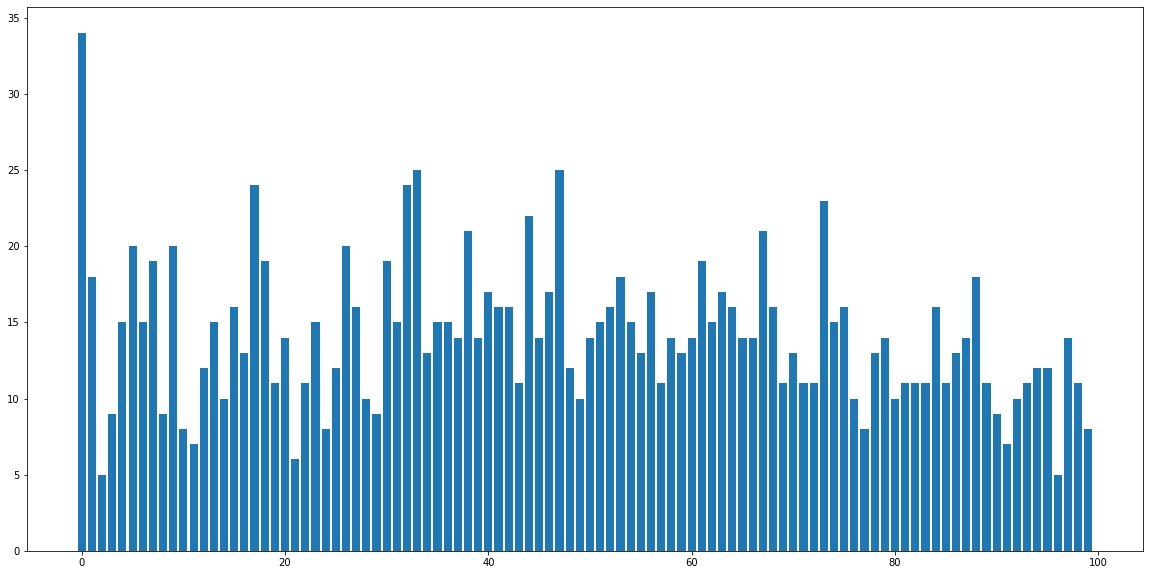

In [140]:
plt.bar(x = arr[0], height = arr[1])

In [142]:
five_or_more_articles = len([x for x in articles_count if x >= 5])
five_or_more_articles

100

In [143]:
ten_or_more_articles = len([x for x in articles_count if x >= 10])
ten_or_more_articles

87

### Now we have filtered based on length. Results are in folder 'dataset_original_en_no_dots_no_cookies_truncated_len_filtered'.

### Total files = 1417

# 4. Generate first N combinations of the dataset

Get the cases directories in a dictionary in the format "Case ID" : \[list of directories of the documents\]

In [144]:
def getSrcDict(src_dir):
    cases_dict = {}
    subfolders = [f.path for f in os.scandir(src_dir) if f.is_dir()]
    i = 0
    for f in subfolders:
        lst = []
        for filename in os.listdir(f):
            lst.append(f + '\\' + filename)
        cases_dict[i] = lst
        i+=1
    
    return cases_dict

In [145]:
cases = getSrcDict(working_dir)

In [146]:
cases

{0: ['C:\\Thesis\\Homicide_dataset_clean\\dataset_original_en_no_dots_no_cookies_truncated_len_filtered\\Case_ID_001_cleaned\\Source_ID_0001_Eng.txt',
  'C:\\Thesis\\Homicide_dataset_clean\\dataset_original_en_no_dots_no_cookies_truncated_len_filtered\\Case_ID_001_cleaned\\Source_ID_0002_Eng.txt',
  'C:\\Thesis\\Homicide_dataset_clean\\dataset_original_en_no_dots_no_cookies_truncated_len_filtered\\Case_ID_001_cleaned\\Source_ID_0003_Eng.txt',
  'C:\\Thesis\\Homicide_dataset_clean\\dataset_original_en_no_dots_no_cookies_truncated_len_filtered\\Case_ID_001_cleaned\\Source_ID_0004_Eng.txt',
  'C:\\Thesis\\Homicide_dataset_clean\\dataset_original_en_no_dots_no_cookies_truncated_len_filtered\\Case_ID_001_cleaned\\Source_ID_0005_Eng.txt',
  'C:\\Thesis\\Homicide_dataset_clean\\dataset_original_en_no_dots_no_cookies_truncated_len_filtered\\Case_ID_001_cleaned\\Source_ID_0006_Eng.txt',
  'C:\\Thesis\\Homicide_dataset_clean\\dataset_original_en_no_dots_no_cookies_truncated_len_filtered\\Case_ID

In [149]:
def getFirstN(src_dict, src_dir, N):
    dst_dir = src_dir + '_' + str(N)
    try:
        os.mkdir(dst_dir)
    except OSError:
        print ("Creation of the directory %s failed" % dst_dir)

    for k in src_dict:
        files = src_dict[k][:N]
        if(len(files) == N):
            case_dir = files[0].split('\\')[-2]
            case_dir = dst_dir + '\\' + case_dir
            
            try:
                os.mkdir(case_dir)
            except OSError:
                print ("Creation of the directory %s failed" % case_dir)

            for f in files:
                shutil.copy(f, case_dir)

In [150]:
getFirstN(cases, working_dir, 2)

In [151]:
getFirstN(cases, working_dir, 3)

In [152]:
getFirstN(cases, working_dir, 4)

In [153]:
getFirstN(cases, working_dir, 5)

In [154]:
getFirstN(cases, working_dir, 6)

In [155]:
getFirstN(cases, working_dir, 7)

In [156]:
getFirstN(cases, working_dir, 8)

In [157]:
getFirstN(cases, working_dir, 9)

In [158]:
getFirstN(cases, working_dir, 10)

# 5. Truncate first 2, 3, 4, and 5 at 500

In [159]:
TOTAL_WORDS = 500

In [162]:
tag = 'story_separator_special_tag'

In [160]:
def generateCorpus(src_dir, separator_tag):
    result = []
    dirFlag = True
    for subdir, _, files in os.walk(src_dir):
        if(dirFlag):
            dirFlag = False
            continue
        tmp_res = []
        for f in files:
            file_path = os.path.join(subdir, f)
            with open(file_path, encoding='utf-8') as doc:
                tmp_res.append(doc.read())
        result.append((" " + separator_tag + " ").join(tmp_res))
        
    return result

In [171]:
corpus_2 = generateCorpus(working_dir + "_2", tag)
corpus_3 = generateCorpus(working_dir + "_3", tag)
corpus_4 = generateCorpus(working_dir + "_4", tag)
corpus_5 = generateCorpus(working_dir + "_5", tag)
# corpus_6 = generateCorpus(working_dir + "_6", tag)
# corpus_7 = generateCorpus(working_dir + "_7", tag)
# corpus_8 = generateCorpus(working_dir + "_8", tag)
# corpus_9 = generateCorpus(working_dir + "_9", tag)
# corpus_10 = generateCorpus(working_dir + "_10", tag)

In [179]:
with open(working_dir + '_2' + '\corpus.txt', 'w', encoding='utf-8') as doc:
    doc.writelines("%s\n" % line for line in corpus_2)
with open(working_dir + '_3' + '\corpus.txt', 'w', encoding='utf-8') as doc:
    doc.writelines("%s\n" % line for line in corpus_3)
with open(working_dir + '_4' + '\corpus.txt', 'w', encoding='utf-8') as doc:
    doc.writelines("%s\n" % line for line in corpus_4)
with open(working_dir + '_5' + '\corpus.txt', 'w', encoding='utf-8') as doc:
    doc.writelines("%s\n" % line for line in corpus_5)

In [183]:
def truncateCorpus(corpus, truncate_words, separator_tag):
    result = []
    for count, line in enumerate(corpus):
        print(f"example number: {count}")
        line_word_split = line.split()
        if len(line_word_split) < truncate_words:
            result.append(line)
            print("total length = {}".format(len(line_word_split)))
            print("=============================================")
        else:
            sources_split = line.split(separator_tag)
            # previous dataset had separator at the end of each example
            if sources_split[-1] == "":
                del sources_split[-1]
            num_sources = len(sources_split)
            words_ar = [source.split() for source in sources_split]
            num_words_ar = [len(words) for words in words_ar]
            print(f"initial number of words: {str(num_words_ar)}")
            per_source_count = math.floor(truncate_words / num_sources)
            total_ar = [0] * num_sources
            total = 0
            done = {}
            while total < truncate_words and len(done) < len(num_words_ar):
                # e.g. total=499 and still trying to add -- just add from the first doc which isn't done
                if per_source_count == 0:
                    for index, x in enumerate(total_ar):
                        if index not in done:
                            total_ar[index] += truncate_words - total
                            break
                    break
                min_amount = min(min([x for x in num_words_ar if x > 0]), per_source_count)
                total_ar = [x + min_amount if index not in done else x for index, x in enumerate(total_ar)]
                for index, val in enumerate(num_words_ar):
                    if val == min_amount:
                        done[index] = True
                num_words_ar = [x - min_amount for x in num_words_ar]
                total = sum(total_ar)
                if len(done) == len(num_words_ar):
                    break
                per_source_count = math.floor((TOTAL_WORDS - total) / (len(num_words_ar) - len(done))) 
            final_words_ar = []
            for count_words, words in enumerate(words_ar):
                cur_string = " ".join(words[:total_ar[count_words]])
                final_words_ar.append(cur_string)
            final_str = (" " + separator_tag + " ").join(final_words_ar).strip() # e.g. " story_separator_special_tag "
            result.append(final_str)
            print("final word count for each source:", total_ar)
            print("=============================================")

    return result

In [185]:
corpus_2_500 = truncateCorpus(corpus_2, TOTAL_WORDS, 'story_separator_special_tag')

example number: 0
initial number of words: [340, 690]
final word count for each source: [250, 250]
example number: 1
initial number of words: [551, 483]
final word count for each source: [250, 250]
example number: 2
initial number of words: [44, 842]
final word count for each source: [44, 456]
example number: 3
initial number of words: [492, 224]
final word count for each source: [276, 224]
example number: 4
initial number of words: [796, 44]
final word count for each source: [456, 44]
example number: 5
initial number of words: [64, 603]
final word count for each source: [64, 436]
example number: 6
total length = 325
example number: 7
initial number of words: [749, 378]
final word count for each source: [250, 250]
example number: 8
initial number of words: [317, 283]
final word count for each source: [250, 250]
example number: 9
total length = 347
example number: 10
total length = 466
example number: 11
initial number of words: [391, 435]
final word count for each source: [250, 250]
ex

In [186]:
corpus_3_500 = truncateCorpus(corpus_3, TOTAL_WORDS, 'story_separator_special_tag')

example number: 0
initial number of words: [340, 690, 489]
final word count for each source: [168, 166, 166]
example number: 1
initial number of words: [551, 483, 983]
final word count for each source: [168, 166, 166]
example number: 2
initial number of words: [44, 842, 229]
final word count for each source: [44, 228, 228]
example number: 3
initial number of words: [492, 224, 221]
final word count for each source: [168, 166, 166]
example number: 4
initial number of words: [796, 44, 354]
final word count for each source: [228, 44, 228]
example number: 5
initial number of words: [64, 603, 89]
final word count for each source: [64, 347, 89]
example number: 6
total length = 488
example number: 7
initial number of words: [749, 378, 547]
final word count for each source: [168, 166, 166]
example number: 8
initial number of words: [317, 283, 223]
final word count for each source: [168, 166, 166]
example number: 9
initial number of words: [295, 51, 866]
final word count for each source: [225, 5

In [187]:
corpus_4_500 = truncateCorpus(corpus_4, TOTAL_WORDS, 'story_separator_special_tag')

example number: 0
initial number of words: [340, 690, 489, 723]
final word count for each source: [125, 125, 125, 125]
example number: 1
initial number of words: [551, 483, 983, 527]
final word count for each source: [125, 125, 125, 125]
example number: 2
initial number of words: [44, 842, 229, 197]
final word count for each source: [44, 152, 152, 152]
example number: 3
initial number of words: [492, 224, 221, 204]
final word count for each source: [125, 125, 125, 125]
example number: 4
initial number of words: [796, 44, 354, 246]
final word count for each source: [152, 44, 152, 152]
example number: 5
initial number of words: [64, 603, 89, 607]
final word count for each source: [64, 174, 89, 173]
example number: 6
initial number of words: [162, 162, 162, 392]
final word count for each source: [125, 125, 125, 125]
example number: 7
initial number of words: [749, 378, 547, 278]
final word count for each source: [125, 125, 125, 125]
example number: 8
initial number of words: [317, 283, 22

In [188]:
corpus_5_500 = truncateCorpus(corpus_5, TOTAL_WORDS, 'story_separator_special_tag')

example number: 0
initial number of words: [340, 690, 489, 723, 385]
final word count for each source: [100, 100, 100, 100, 100]
example number: 1
initial number of words: [551, 483, 983, 527, 482]
final word count for each source: [100, 100, 100, 100, 100]
example number: 2
initial number of words: [44, 842, 229, 197, 330]
final word count for each source: [44, 114, 114, 114, 114]
example number: 3
initial number of words: [492, 224, 221, 204, 206]
final word count for each source: [100, 100, 100, 100, 100]
example number: 4
initial number of words: [796, 44, 354, 246, 119]
final word count for each source: [114, 44, 114, 114, 114]
example number: 5
initial number of words: [64, 603, 89, 607, 310]
final word count for each source: [64, 117, 89, 115, 115]
example number: 6
initial number of words: [162, 162, 162, 392, 73]
final word count for each source: [109, 106, 106, 106, 73]
example number: 7
initial number of words: [749, 378, 547, 278, 385]
final word count for each source: [100

In [190]:
with open(working_dir + '_2' + '\corpus_2_' + str(TOTAL_WORDS) + '.txt', 'w', encoding='utf-8') as doc:
    doc.writelines("%s\n" % line for line in corpus_2_500)
with open(working_dir + '_3' + '\corpus_3_' + str(TOTAL_WORDS) + '.txt', 'w', encoding='utf-8') as doc:
    doc.writelines("%s\n" % line for line in corpus_3_500)
with open(working_dir + '_4' + '\corpus_4_' + str(TOTAL_WORDS) + '.txt', 'w', encoding='utf-8') as doc:
    doc.writelines("%s\n" % line for line in corpus_4_500)
with open(working_dir + '_5' + '\corpus_5_' + str(TOTAL_WORDS) + '.txt', 'w', encoding='utf-8') as doc:
    doc.writelines("%s\n" % line for line in corpus_5_500)

# 6. Truncate first 2, 3, 4, and 5 at 1000

In [191]:
TOTAL_WORDS = 1000

In [192]:
corpus_2_1000 = truncateCorpus(corpus_2, TOTAL_WORDS, 'story_separator_special_tag')
corpus_3_1000 = truncateCorpus(corpus_3, TOTAL_WORDS, 'story_separator_special_tag')
corpus_4_1000 = truncateCorpus(corpus_4, TOTAL_WORDS, 'story_separator_special_tag')
corpus_5_1000 = truncateCorpus(corpus_5, TOTAL_WORDS, 'story_separator_special_tag')

example number: 0
initial number of words: [340, 690]
final word count for each source: [340, 660]
example number: 1
initial number of words: [551, 483]
final word count for each source: [517, 483]
example number: 2
total length = 887
example number: 3
total length = 717
example number: 4
total length = 841
example number: 5
total length = 668
example number: 6
total length = 325
example number: 7
initial number of words: [749, 378]
final word count for each source: [622, 378]
example number: 8
total length = 601
example number: 9
total length = 347
example number: 10
total length = 466
example number: 11
total length = 827
example number: 12
initial number of words: [583, 580]
final word count for each source: [500, 500]
example number: 13
total length = 735
example number: 14
initial number of words: [921, 134]
final word count for each source: [866, 134]
example number: 15
total length = 995
example number: 16
total length = 478
example number: 17
initial number of words: [749, 823]

In [193]:
with open(working_dir + '_2' + '\corpus_2_' + str(TOTAL_WORDS) + '.txt', 'w', encoding='utf-8') as doc:
    doc.writelines("%s\n" % line for line in corpus_2_1000)
with open(working_dir + '_3' + '\corpus_3_' + str(TOTAL_WORDS) + '.txt', 'w', encoding='utf-8') as doc:
    doc.writelines("%s\n" % line for line in corpus_3_1000)
with open(working_dir + '_4' + '\corpus_4_' + str(TOTAL_WORDS) + '.txt', 'w', encoding='utf-8') as doc:
    doc.writelines("%s\n" % line for line in corpus_4_1000)
with open(working_dir + '_5' + '\corpus_5_' + str(TOTAL_WORDS) + '.txt', 'w', encoding='utf-8') as doc:
    doc.writelines("%s\n" % line for line in corpus_5_1000)